<a href="https://colab.research.google.com/github/YangRyRay/cs480student/blob/main/06/Copy_of_CS480_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

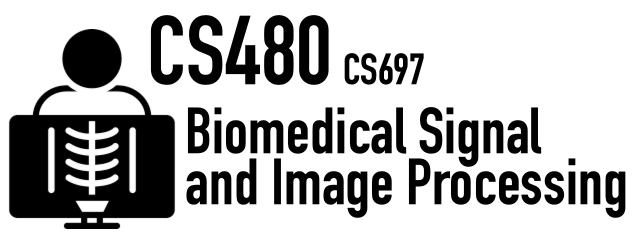
#Assignment 6

In [1]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [2]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [3]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-ve7wqfv7
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-ve7wqfv7
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25658 sha256=e46150c2e10f7ae7c3cabee121915d5f8d409415e280be689ea00450bd4812b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-kz_m1gtx/wheels/f5/38/c8/8f0a157cfd7616cc1a24811a52b9a669c0ee8fccc9f99d3cbc
Successfully built unet


In [5]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [6]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [7]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [8]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [9]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.
#
# TODO: YOUR ANSWER
# The U-Net is trained to identify circles in the provided image data.

In [10]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2
#
# TODO: YOUR ANSWER

# Channels and classes are some descriptive information about the data that can 
# be used to inform the U-net, or any sort of classification algorithm. The 
# channels indicate how many sources or streams of data there are. For this 
# example, there is one source of data. The classes indicate how many different 
# "bins" there are to sort the items. In this example, there are 2 classes each 
# item, or pixel, in the image can be, either part of a circle, or not part of 
# a circle.

In [11]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!
#
# TODO: YOUR ANSWER
# Mitochondria are "the powerhouse of the cell", they are organelles within 
# cells responsible for generating the energy required for operation in cells. 
# In electron microscopy, they tend to appear as circles or sort of rice-grain 
# shaped, with lateral stripes 

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [12]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [13]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # TODO: Normalize the image to 0..1
        #
        # TODO: YOUR CODE

        image = tf.cast(image, tf.float32) / 255.0
        #mask = mask/255
        
        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)
        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
            #
            # TODO: YOUR CODE
            #
            image = tf.image.rot90(image)
            mask = tf.image.rot90(mask)


        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [15]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

In [21]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
#
# TODO: YOUR ANSWER

# The train-val-test split specifies .7 for train, so we expect about 70% of the images to be used for training.
# 660x0.7=462 therefore there should be 462 images used for training.
print(len(train))
# I am unsure why this length was actually 461, probably some rounding error

461


In [17]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [18]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [19]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model,
            #
            # TODO: YOUR CODE
            #
            #
            train,
            val,
            epochs=50,
            batch_size = 10)

Epoch 1/50
47/47 [==============================] - 61s 1s/step - loss: 0.5784 - categorical_crossentropy: 0.5784 - categorical_accuracy: 0.8390 - mean_iou: 0.3257 - dice_coefficient: 0.5983 - auc: 0.8145 - val_loss: 0.4041 - val_categorical_crossentropy: 0.4041 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3626 - val_dice_coefficient: 0.6751 - val_auc: 0.9848
Epoch 2/50
47/47 [==============================] - 40s 844ms/step - loss: 0.3179 - categorical_crossentropy: 0.3179 - categorical_accuracy: 0.9210 - mean_iou: 0.4409 - dice_coefficient: 0.8335 - auc: 0.9339 - val_loss: 0.3129 - val_categorical_crossentropy: 0.3129 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.4010 - val_dice_coefficient: 0.7476 - val_auc: 0.9831
Epoch 3/50
47/47 [==============================] - 39s 830ms/step - loss: 0.2928 - categorical_crossentropy: 0.2928 - categorical_accuracy: 0.9210 - mean_iou: 0.4461 - dice_coefficient: 0.8415 - auc: 0.9410 - val_loss: 0.2031 - val_categorical_crossentropy

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [20]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

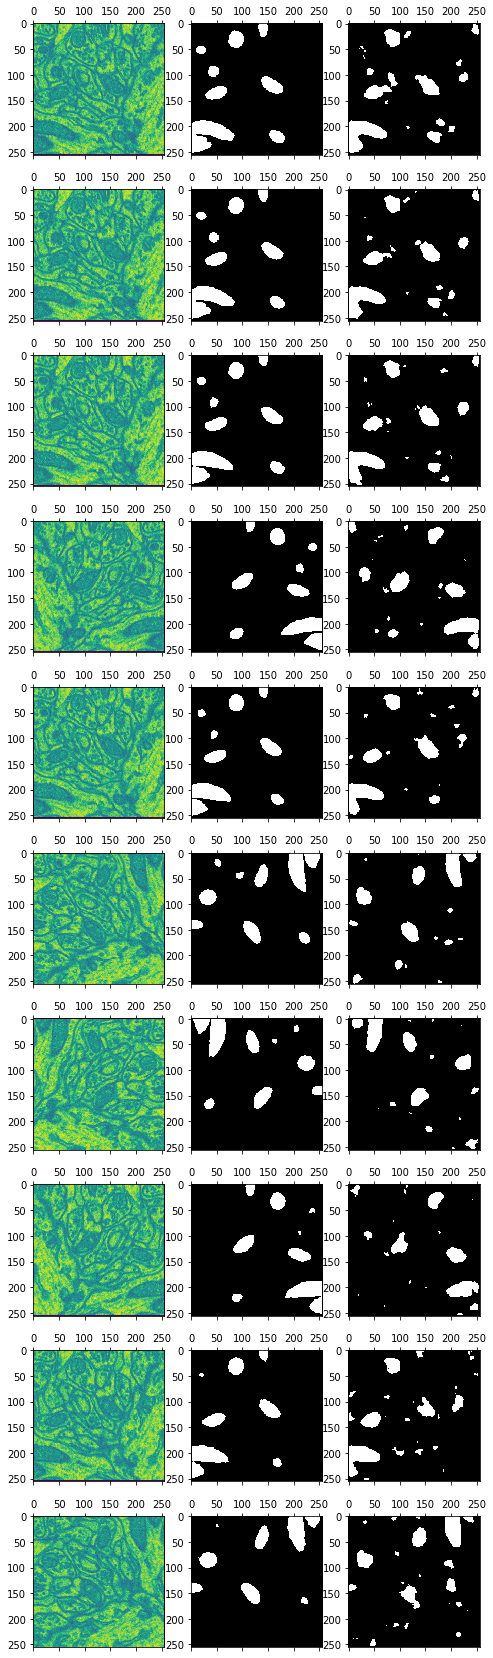

In [64]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")


In [19]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?
# 
# TODO: YOUR ANSWER
# The prediction[0].argmax(axis=-1) command is used to to display the prediction
# so that the proper array of values is called. The prediction is a 3D array of
# size (1,256,256,2). The first dimension realates to how many image arrays are
# input at a time, and thus how many predictions are made at a time. Since we
# are only predicting one image at a time, there is only one object in this
# dimension, so we call the 0'th index object to remove the nominal dimension.
# The remainder of the data is what we are interested in. For each prediction,
# we have 2 arrays of 256 by 256 values, creating the (256,256,2) shape. Each
# value predicts the probability that the pixel in the location determined by 
# the two 256 dimensions is a value of the class determined by the 2 dimension,
# either at index 0 (not a mitochondria pixel) or 1 (a mitochondria pixel). In 
# order to predict each pixel and project them into a single 256x256 array, 
# argmax is used to find the index with the maximum value (probability) per
# pixel location. In order to do that, the axis for argmax needed to be
# specified as the last dimension, hence the axis=-1. Alternatively, axis=2
# could have also been used.

In [ ]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: YOUR ANSWER
# Yes, I believe the segmentation quality is ok, not great. From the first
# handful of images, it looks like most of the larger bodies of mitochondria are 
# identified, with some missing smaller ones and some artifacting in the
# prediction. In order to improve the segmentation, there could be some
# information provided to the model, like a minimum expected size for a
# mitochondria pixel collection. That should clean up some of the random
# false positive predictions. Another helpful information that could be provided
# is the shape of the mitochondria, this should clear up some of the concavity
# and holes in the predicted mitochondria bodies.

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [ ]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [ ]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#
# The model has 31,030,658 parameters, all of them trainable.

In [25]:
# TODO: YOUR CODE
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block_27 (ConvBlock)       (None, None, None, 6 37568       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, None, None, 6 0           conv_block_27[0][0]              
__________________________________________________________________________________________________
conv_block_28 (ConvBlock)       (None, None, None, 1 221440      max_pooling2d_12[0][0]           
_______________________________________________________________________________________________

In [ ]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#
# Casser et al. has 1,178,480 parameters for encoding and 780,053 for decoding,
# for a total of 1,958,533 parameters

In [ ]:
# TODO: YOUR ANSWER
#
# Casser et al. has 1,178,480 parameters for encoding and 780,053 for decoding,
# for a total of 1,958,533 parameters

In [ ]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#
# There were several things done in order to reduce the number of parameters.
# First, the number of convolutional filters in the network was decreased. 
# Next, transpose  convolutions  were replaced with light-weight bilinear 
# upsampling layers, which do not have additional parameters. 

In [ ]:
# TODO: YOUR ANSWER
#
# There were several things done in order to reduce the number of parameters.
# First, the number of convolutional filters in the network was decreased. 
# Next, transpose  convolutions  were replaced with light-weight bilinear 
# upsampling layers, which do not have additional parameters. 

In [ ]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#
# The main reason to reduce the parameters is to reduce the necessary number of
# computations. By reducing the number of computations, a significant amount of
# processing time can be removed. They were able to reduce the number of
# computations because it was discovered that the original model, over a third
# of the ReLU activations were permanently inactive, not contributing to the
# learning or predicting of the model.

In [ ]:
# TODO: YOUR ANSWER
#
# The main reason to reduce the parameters is to reduce the necessary number of
# computations. By reducing the number of computations, a significant amount of
# processing time can be removed. They were able to reduce the number of
# computations because it was discovered that the original model, over a third
# of the ReLU activations were permanently inactive, not contributing to the
# learning or predicting of the model.

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#